## Questions
- How to break the data into train / test? Most of what I've seen is just splitting the data set into a test / train split, not based on X_test / X_train and y_test / y_train.

randomly select a division for X_train, X_test, y_train, y_test like before

- Do I need to drop the text columns now that I have all my data merged? If I drop STATION, will it matter that for some years I have two or more data points?

Don't drop STATION - change to number / categorical

- The above questions actually leads me to the most critical question about the data - how should I structure it? I'm reading through a good article (that is very dense) and the data for these examples are simply numeric arrays, one for each time step, and the output expected on each layer (for later examples). How would I need to restructure my dataframe here? I'll keep looking for more examples, but the repetition of data for some years and not others feels like it could be a problem.

No need to restructure the dataframe - the number of columns reps the matrix, and will be apparent in the X_train/X_test/y_train/y_test variables

- Number of features? I think three: 3 (PRCP, TMIN, TMAX) These are my three features

- Number of target variables? I think just one: 1 (Yield(Unit/Acre)

We train and test on the three variables - we are predicting the future of the variables (Or I get to choose the number of variables). All four of these variables related, but only Yield would be dependent on precip and temp

- Is this a Multivariate LSTM model because I have 4 observations per time step?

more layers is more complex - start with one layer? One LSTM layer, at least. Consider other layers to add based on the Kaggle article, and the other walkthrough article. 

- What Features to consider for LSTM specifically?

PRCP, TMIN, TMAX

- How many layers? How many LSTM layers to add to a Sequential Model? One per variable (so, three?)

Dropout layer, Dense layer - look up different layers. Aim for 85% on test

- Is the Sequential Model the correct model to use?

yes holds the different layers, including LSTM layers

- I found an article that adds a "Dense" layer (?) to the model - is that necessary? What does that do?

When I compile the model, what parameters should I pass? Do you have a good example? in one article I see specifying an optimizer and a loss param).

Look up the params I find in the articles - why mse vs. the categorical_crossentropy ? one is for numerical (mse) and the other seems to be for categorical classification



In [223]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import Input

In [182]:
df = pd.read_csv('./data/df_final.csv')

In [183]:
df.head()

,STATION,PRCP,TMAX,TMIN,Year,County,Yield(Unit/Acre)
0,USC00048351,0.0,NaN,NaN,1980,Sonoma,3.34
1,USC00048351,0.0,53.0,38.0,1981,Sonoma,3.39
2,USC00048351,0.5,51.0,35.0,1982,Sonoma,4.00
3,USC00048351,0.0,48.0,32.0,1983,Sonoma,3.14
4,USC00048351,0.0,63.0,36.0,1984,Sonoma,3.81


In [184]:
df.isna().sum()

STATION              0
PRCP                26
TMAX                52
TMIN                55
Year                 0
County               0
Yield(Unit/Acre)     0
dtype: int64

In [185]:
df['PRCP'] = df['PRCP'].transform(lambda x: x.fillna(x.median()))
df['TMIN'] = df['TMIN'].transform(lambda x: x.fillna(x.median()))
df['TMAX'] = df['TMAX'].transform(lambda x: x.fillna(x.median()))

In [186]:
df.isna().sum()

STATION             0
PRCP                0
TMAX                0
TMIN                0
Year                0
County              0
Yield(Unit/Acre)    0
dtype: int64

<Axes: xlabel='Year', ylabel='PRCP'>

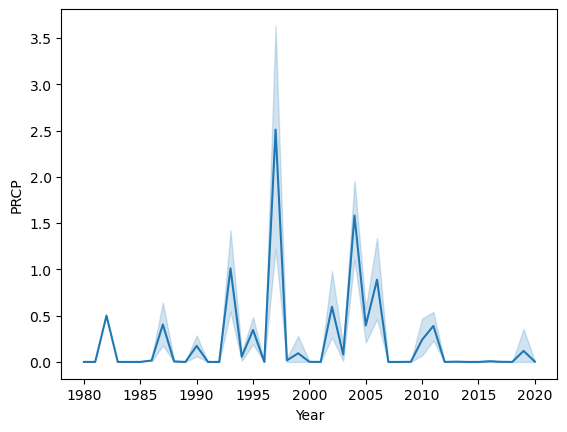

In [215]:
sns.lineplot(data=df, x='Year', y='PRCP')

<Axes: xlabel='Year', ylabel='TMIN'>

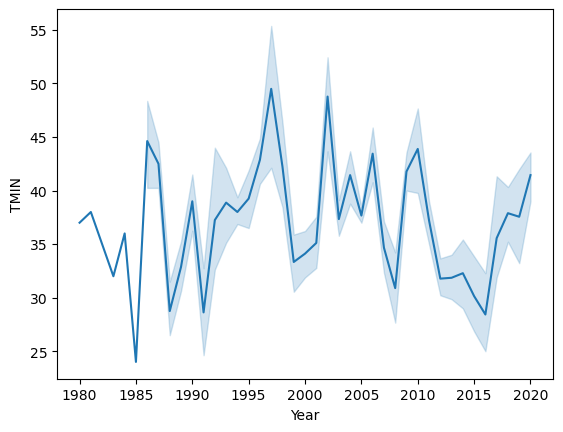

In [216]:
sns.lineplot(data=df, x='Year', y='TMIN')

<Axes: xlabel='Year', ylabel='TMAX'>

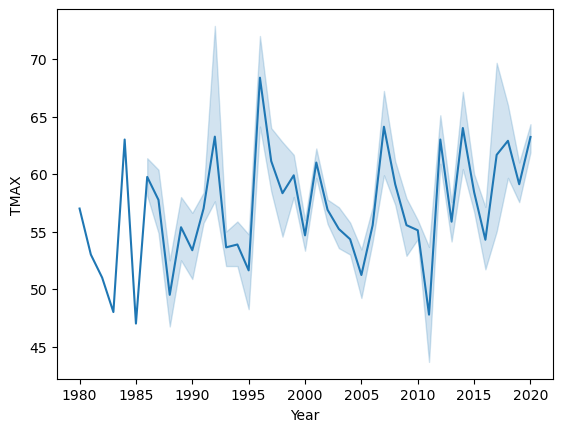

In [217]:
sns.lineplot(data=df, x='Year', y='TMAX')

<Axes: xlabel='Year', ylabel='Yield(Unit/Acre)'>

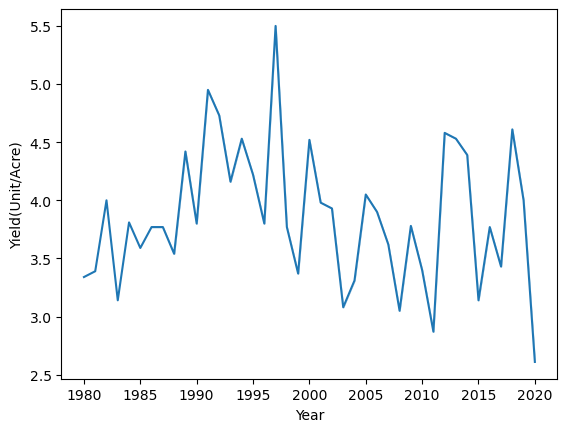

In [218]:
sns.lineplot(data=df, x='Year', y='Yield(Unit/Acre)')

In [187]:
# only drop a column that won't have an impact on my selection
df = df.drop(['County'], axis=1)

In [188]:
stations = df.STATION.unique()
print(len(stations))
print(stations)

9
['USC00048351' 'USC00047965' 'USC00043578' 'USC00043875' 'USC00046370'
 'USC00046826' 'USC00043191' 'USC00041838' 'USW00023213']


In [189]:
df['STATION'] = df['STATION'].str.slice(6, 11)

In [190]:
df['STATION'] = df['STATION'].astype(int)

In [191]:
df.dtypes

STATION               int64
PRCP                float64
TMAX                float64
TMIN                float64
Year                  int64
Yield(Unit/Acre)    float64
dtype: object

In [192]:
df.head()

,STATION,PRCP,TMAX,TMIN,Year,Yield(Unit/Acre)
0,48351,0.0,57.0,37.0,1980,3.34
1,48351,0.0,53.0,38.0,1981,3.39
2,48351,0.5,51.0,35.0,1982,4.00
3,48351,0.0,48.0,32.0,1983,3.14
4,48351,0.0,63.0,36.0,1984,3.81


In [193]:
X = df.drop(['Yield(Unit/Acre)'], axis = 1)
y = df['Yield(Unit/Acre)']

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1)

In [246]:
# steps is how many times I want my model to train. Maybe 10, maybe 20 - how many times the model cycles through
# The model learns every step - it is cumulative 
n_steps = 10

# The models knows the features based on the columns
n_features = 3

# for units (?)
print(X_train.shape, y_train.shape)
print(n_steps, n_features)

(225, 5) (225,)
10 3


In [245]:
# https://keras.io/api/models/model_training_apis/
model = Sequential()
model.add(Input(shape=(n_steps, n_features)))
model.add(LSTM(225))
model.add(Dense(1))
# https://faroit.com/keras-docs/1.1.0/optimizers/
model.compile(optimizer='sgd', loss='mse')

In [243]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 225)            │       206,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           226 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,326 (805.96 KB)

 Trainable params: 206,326 (805.96 KB)

 Non-trainable params: 0 (0.00 B)

In [244]:
model.fit(X_train, y_train, epochs=10, verbose=2)

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 5), dtype=float32). Expected shape (None, 10, 3), but input has incompatible shape (None, 5)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 5), dtype=float32)
  • training=True
  • mask=None